In [1]:
# Import principaux utilisés dans l'ensemble du notebook
from methods import cleaning_methods
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from scipy import stats
import random
import time


# Table des matières 

- I — Acquisition des données (tickers, prix)
- II — Pré-traitement (nettoyage, filtres)
- III — Échantillonnage & métriques (sample, estimate_nu, GMV, Markowitz)
- V — Benchmarks (MV, Frobenius, KS)
- VI — Analyses spectrales
- VII — Simulation Monte Carlo & visualisations

In [2]:
def L_mv(Sigma_hat, Sigma):
    p = Sigma.shape[0]

    d, U = np.linalg.eigh(Sigma_hat)
    d = np.maximum(d, 1e-8)
    Sigma_hat_inv = U @ np.diag(1 / d) @ U.T

    Sigma_inv = np.linalg.inv(Sigma)

    num = np.trace(Sigma_hat_inv @ Sigma @ Sigma_hat_inv) / p
    den = (np.trace(Sigma_hat_inv) / p) ** 2
    cst = 1 / (np.trace(Sigma_inv) / p)

    return num / den - cst

def corr(X):
    Xc = X - X.mean(axis=0)
    S = Xc.T @ Xc / (Xc.shape[0] - 1)
    d = np.sqrt(np.diag(S))
    return S / np.outer(d, d)

In [ ]:
# === II — Acquisition des données ===
# Web-scraping et agrégation de tickers
# Note: les imports sont centralisés en début de notebook

urls = ["https://en.wikipedia.org/wiki/List_of_S%26P_500_companies", "https://en.wikipedia.org/wiki/NASDAQ-100", "https://www.ishares.com/us/products/239707/ishares-russell-3000-etf/1467271812596.ajax?fileType=csv"]

tickers = []

options = Options()
options.add_argument('--headless')

driver = webdriver.Chrome(options=options)

for url in urls:
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    for link in soup.find_all('a', class_='external text'):
        symbole = link.get_text()
        tickers.append(symbole)

url_euro = 'https://stockanalysis.com/list/euronext-paris/'

driver.get(url_euro)
html = driver.page_source
tables = pd.read_html(html)
if len(tables) > 0:
    tickers_euro = tables[0]['Symbol'].tolist()
    tickers = tickers + tickers_euro

print(len(np.unique(tickers)))

# Merge with local list (CSV)
local_universe_path = 'C:/Users/hugo.vigna/OneDrive - Exiom Partners/Bureau/Matrices/500_assets_universe.csv'
if os.path.exists(local_universe_path):
    data = pd.read_csv(local_universe_path)
    tickers_ = data.to_numpy().tolist()
    for l in tickers_:
        tickers.append(l[0])

# Basic filtering
tickers = list(set(tickers))
tickers = [ticker for ticker in tickers if len(ticker) < 10]
print(tickers)
print(len(tickers))

# Enregistrer la liste brute
pd.DataFrame(tickers).to_csv("all_tickers.csv", index=False, header=False)

C:\Users\hugo.vigna\AppData\Local\Temp\ipykernel_13584\1503270957.py:29: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


1369
['CRAV', 'APD', 'GOOGL', 'ALGN', 'MLHOT', 'THEP', 'MMT', 'ALDEL', 'PNR', 'ALERS', 'CAT', 'AIG', 'SEE', 'CF', 'ROP', 'ALECR', 'LOW', 'ALPHI', 'JPM', 'HCO', 'ADOC', 'MMM', 'INVH', 'SAVE', 'MTU', 'ETF407', 'IEX', 'ALLLN', 'BG', 'ALPRG', 'MGM', 'MRN', 'ETF467', 'PFE', 'ETF354', 'ETF342', 'MLVIN', 'EKI', 'ETF358', 'MOS', 'ETF367', 'OPM', 'DE', 'AMUN', 'SBT', 'CPB', 'ORA', 'DELL', 'ALCRB', 'NXPI', 'CINF', 'GEV', 'AIR', 'EA', 'MNST', 'ANTIN', 'WEC', 'ETF327', 'APO', 'SLB', 'COTY', 'VETO', 'KKR', 'UDR', 'ALGTR', 'ALTHX', 'ETF487', 'KVUE', 'MLJDL', 'VST', 'BALYO', 'TAP', 'AMZN', 'COIN', 'DLR', 'HOLX', 'ALCOX', 'COP', 'CHD', 'CMS', 'MLCHE', 'PODD', 'ETF388', 'ETF493', 'VIRI', 'GEHC', 'ORLY', 'SNDK', 'ETF483', 'ALDMS', 'COR', 'MF', 'EG', 'LYV', 'MCD', 'HRL', 'CAT31', 'CARR', 'CFG', 'AI', 'ALB', 'NVDA', 'FCX', 'MLIFS', 'BLK', 'ETF379', 'AXON', 'LDOS', 'HIG', 'ALLIX', 'DG', 'MLECE', 'MLHMC', 'UBER', 'ETF494', 'ATLD', 'MLARI', 'ABT', 'DGX', 'SBUX', 'PVL', 'ALFUM', 'ALAUD', 'MTB', 'POMRY', 'DHR'

In [9]:
prices.to_csv("prices.csv", index=False, header=False)

In [3]:
# === IV — Échantillonnage & métriques ===
# Fonctions d'échantillonnage et métriques (sample/estimate/GMV/Markowitz)
# Les imports sont centralisés en haut du notebook

prices = pd.read_csv('prices.csv')

def sample_real_data(data, n_is, n_oos, p):
    """Extrait un échantillon in-sample et out-of-sample de la matrice de prix.

    Args:
        data: DataFrame des prix (colonnes = actifs)
        n_is: longueur in-sample
        n_oos: longueur out-of-sample
        p: nombre d'actifs à sélectionner

    Returns:
        X_is, X_oos : arrays (T x p)
    """

    assets = np.random.choice(data.columns, size=p, replace=False)
    t0 = np.random.randint(0, len(data) - n_is - n_oos)

    X_is = data.iloc[t0:t0+n_is][assets].values
    X_oos = data.iloc[t0+n_is:t0+n_is+n_oos][assets].values

    return X_is, X_oos

def gmv_weights(S):
    p = S.shape[0]
    one = np.ones(p)
    w = np.linalg.solve(S, one)
    w /= one @ w
    return w

def markowitz_frontier(S_is, mu_is, S_oos, mu_os, n_points=150):
    """Frontière de Markowitz : optimisation IS, évaluation OOS."""
    p = len(mu_is)
    ones = np.ones(p)

    Sinv = np.linalg.pinv(S_is)

    A = ones @ Sinv @ ones
    B = ones @ Sinv @ mu_is
    C = mu_is @ Sinv @ mu_is
    D = A * C - B**2

    mu_gmv = (ones @ Sinv @ mu_is) / (ones @ Sinv @ ones)
    mu_min = 0.8 * mu_is.min() #mu_gmv
    mu_max = 0.8 * mu_is.max()

    mu_targets = np.linspace(mu_min, mu_max, n_points)

    risks = []
    rets = []
    sharpes = []
    rf = 1.2e-4

    for mu_star in mu_targets:
        w = ((C - B * mu_star) / D) * (Sinv @ ones) \
          + ((A * mu_star - B) / D) * (Sinv @ mu_is)

        risk = np.sqrt(w @ S_oos @ w)
        ret = w @ mu_os
        sharpe = (ret - rf) / risk if risk > 0 else np.nan

        risks.append(risk)
        rets.append(ret)
        sharpes.append(sharpe)

    return risks, rets, sharpes


In [4]:
# === III — Pré-traitement ===
# Nettoyage et sélection des séries de prix
# Les imports sont centralisés en début de notebook

data = prices[prices.columns[(prices > 0).all()]]
R = np.log(data).diff().iloc[1:, :].dropna(axis = 1)

R = np.clip(R, -0.2, 0.2)
R = R.loc[:, R.std() > 1e-6]
R = R.loc[:, R.std() < 0.07]
C = np.corrcoef(R, rowvar=False)
mask = (np.max(np.abs(C - np.eye(C.shape[0])), axis=0) < 0.999)
col_names = R.columns[mask]
R = pd.DataFrame(R.values[:, mask], columns=col_names, index=R.index)

threshold = 1e-6
colonnes_pb = set()
step = 1
window_size = 252

for time in range (0, len(R)- window_size + 1, step):
    volatilites = R.iloc[time : time + window_size, :].std()
    colonnes_pb.update(volatilites[volatilites < threshold].index)

colonnes_pb = list(colonnes_pb)
colonnes_ok = [colonne for colonne in R.columns if colonne not in colonnes_pb]

R = R[colonnes_ok]

moyenne df: 0.0008354021947174911
médiane df: 5.805054145489332e-19
écart type df: 0.003986120044001172
min df: -1.2386840603009265e-17
max df: 0.10967720896006611
moyenne df: 0.024696035674317444
médiane df: 0.01977433642139964
écart type df: 0.015016924341899428
min df: 0.0001683220017402364
max df: 0.09923509581363299


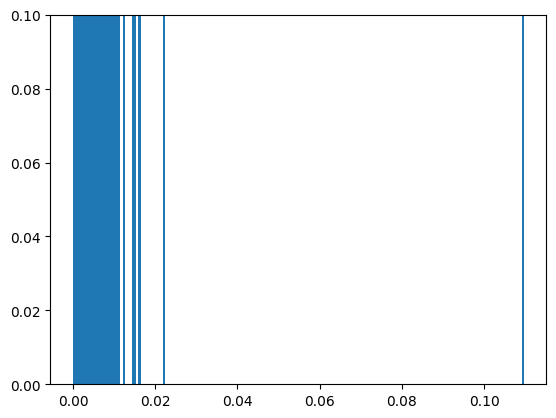

In [43]:
# === VI — Analyses spectrales ===
# Calculs préliminaires: spectre et statistiques descriptives
M = 1
df = []
stds = []

for _  in range(M):    
    X_is, X_oos = sample_real_data(R, 252, 252, 1000)

    mu_is = X_is.mean(axis=0)
    X_is -= mu_is
    lambd = np.linalg.eigvalsh(X_is.T @ X_is / 252)

    for l in lambd:
        df.append(l)

    for i in range(np.shape(X_is)[1]):    
        stds.append(X_is[:,i].std())

print('moyenne df:', np.mean(df))
print('médiane df:', np.median(df))
print('écart type df:', np.std(df))
print('min df:', np.min(df))
print('max df:', np.max(df))

print('moyenne df:', np.mean(stds))
print('médiane df:', np.median(stds))
print('écart type df:', np.std(stds))
print('min df:', np.min(stds))
print('max df:', np.max(stds))

plt.figure()
plt.hist(df, bins = 200, density = True)
plt.ylim(0,0.1)
plt.show()


In [5]:
# === V — Benchmarks ===

import tqdm as tqdm 

n_is = 248
n_oos = 248
n,p = np.shape(R)
print(p)

X_is, X_oos = sample_real_data(R, n_is, n_oos, p)

mu_is = X_is.mean(axis=0)
mu_oos = X_oos.mean(axis=0)

X_is -= mu_is
X_oos -= mu_oos

R_is = X_is.T @ X_is / (n_is-1)
R_os = X_oos.T @ X_oos / (n_oos-1)

cleaner = cleaning_methods(X_is)

S_poet = cleaner.POET()
S_mp = cleaner.mp()
S_mp2 = cleaner.mp2()
S_as = cleaner.analytical_shrinkage()
S_ls = cleaner.linear_shrinkage()

# covariances estimées
S_dict = {
    "Sample": R_is,
    "MP quantile": S_mp,
    "MP théorique": S_mp2,
    "AS": S_as,
    "LS": S_ls,
    "POC": S_poet
}

frontiers = {}

for name, S_hat in tqdm(S_dict.items()):
    risk, ret, sharpe = markowitz_frontier(S_hat, mu_is, R_os, mu_oos, n_points=60)
    frontiers[name] = (risk, ret, sharpe)

1974


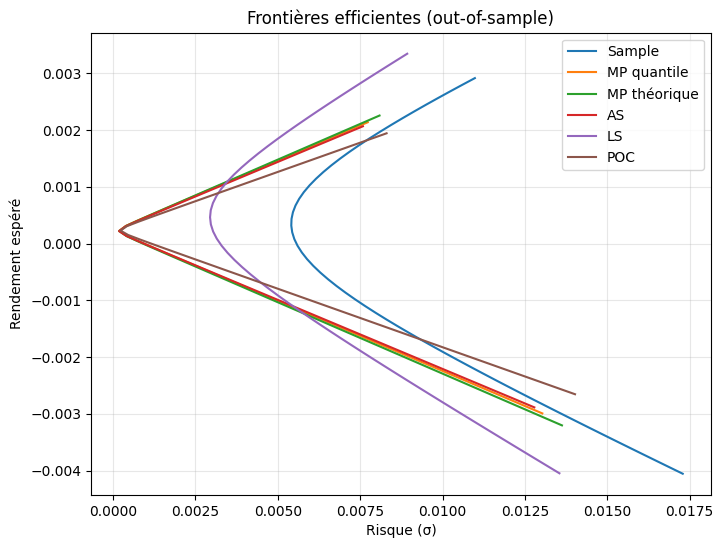

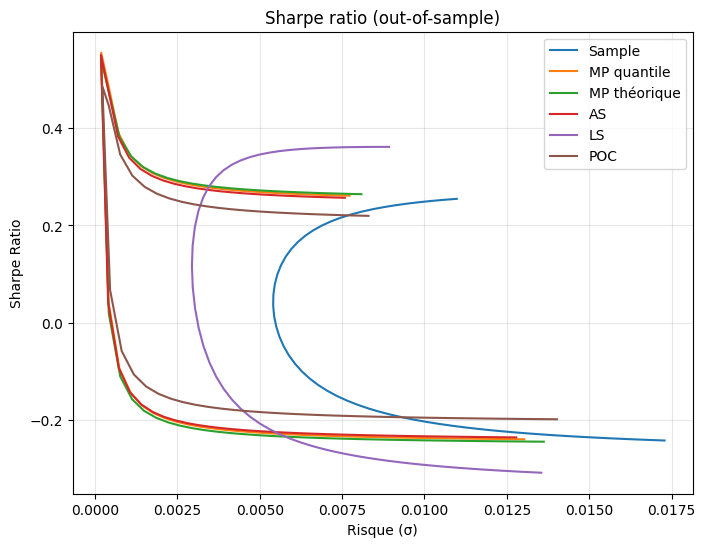

GMV: 0.0001518446060131775


In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

for name, (risk, ret, sharpe) in frontiers.items():
    plt.plot(risk, ret, label=name)

plt.xlabel("Risque (σ)")
plt.ylabel("Rendement espéré")
plt.title("Frontières efficientes (out-of-sample)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,6))

for name, (risk, ret, sharpe) in frontiers.items():
    plt.plot(risk, sharpe, label=name)

plt.xlabel("Risque (σ)")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe ratio (out-of-sample)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

w_gmv = gmv_weights(S_hat)
print('GMV:', np.sqrt(w_gmv @ S_hat @ w_gmv))

#np.max(np.abs(w_sample))

In [8]:
# === VII — Monte Carlo ===
# Monte Carlo Monte-Carlo des frontières (utilise fonctions définies plus haut)
# Les imports sont centralisés en début de notebook

n,p = np.shape(R)
MC_frontier = 50

def mc_frontier_run():
    """Une itération du Monte Carlo"""
    n_is = 248
    n_oos = 248

    X_is, X_oos = sample_real_data(R, n_is, n_oos, p)

    mu_is = X_is.mean(axis=0)
    mu_oos = X_oos.mean(axis=0)

    X_is -= mu_is
    X_oos -= mu_oos

    R_is = X_is.T @ X_is / (n_is-1)
    R_os = X_oos.T @ X_oos / (n_oos-1)

    cleaner = cleaning_methods(X_is)

    S_mp = cleaner.mp()
    S_mp2 = cleaner.mp2()
    S_as = cleaner.analytical_shrinkage()
    S_ls = cleaner.linear_shrinkage()
    S_poet = cleaner.POET()

    # covariances estimées
    S_dict = {
        "Sample": R_is,
        "MP quantile": S_mp,
        "MP théorique": S_mp2,
        "AS": S_as,
        "LS": S_ls,
        "POET": S_poet
    }

    frontiers_run = {}
    for name, S_hat in S_dict.items():
        risk, ret, sharpe = markowitz_frontier(S_hat, mu_is, R_os, mu_oos, n_points=60)
        frontiers_run[name] = (risk, ret, sharpe)

    return frontiers_run

# Lancer le MC
results_mc = Parallel(n_jobs=-1, backend="threading")(
    delayed(mc_frontier_run)() for _ in tqdm(range(MC_frontier))
)

frontiers_mc = {
    "Sample": {"risks": [], "rets": [], "sharpes": []},
    "MP quantile": {"risks": [], "rets": [], "sharpes": []},
    "MP théorique": {"risks": [], "rets": [], "sharpes": []},
    "AS": {"risks": [], "rets": [], "sharpes": []},
    "LS": {"risks": [], "rets": [], "sharpes": []},
    "POET": {"risks": [], "rets": [], "sharpes": []}
}

for result in results_mc:
    for name, (risk, ret, sharpe) in result.items():
        frontiers_mc[name]["risks"].append(risk)
        frontiers_mc[name]["rets"].append(ret)
        frontiers_mc[name]["sharpes"].append(sharpe)

# Calculer les moyenne et écarts-types
frontiers_stats = {}
for name, data in frontiers_mc.items():
    risks_array = np.array(data["risks"])
    rets_array = np.array(data["rets"])
    sharpes_array = np.array(data["sharpes"])

    # Calculer les quantiles point par point
    q1_ret = np.quantile(rets_array, 0.01, axis=0)
    q99_ret = np.quantile(rets_array, 0.99, axis=0)
    q1_sharpe = np.quantile(sharpes_array, 0.01, axis=0)
    q99_sharpe = np.quantile(sharpes_array, 0.99, axis=0)

    frontiers_stats[name] = {
        "risk_mean": risks_array.mean(axis=0),
        "ret_mean": rets_array.mean(axis=0),
        "q1_ret": q1_ret,
        "q99_ret": q99_ret,
        "sharpe_mean": sharpes_array.mean(axis=0),
        "q1_sharpe": q1_sharpe,
        "q99_sharpe": q99_sharpe
    }

print(f"Monte Carlo: {MC_frontier} itérations complétées")

100%|██████████| 50/50 [1:16:37<00:00, 91.95s/it] 


Monte Carlo: 50 itérations complétées


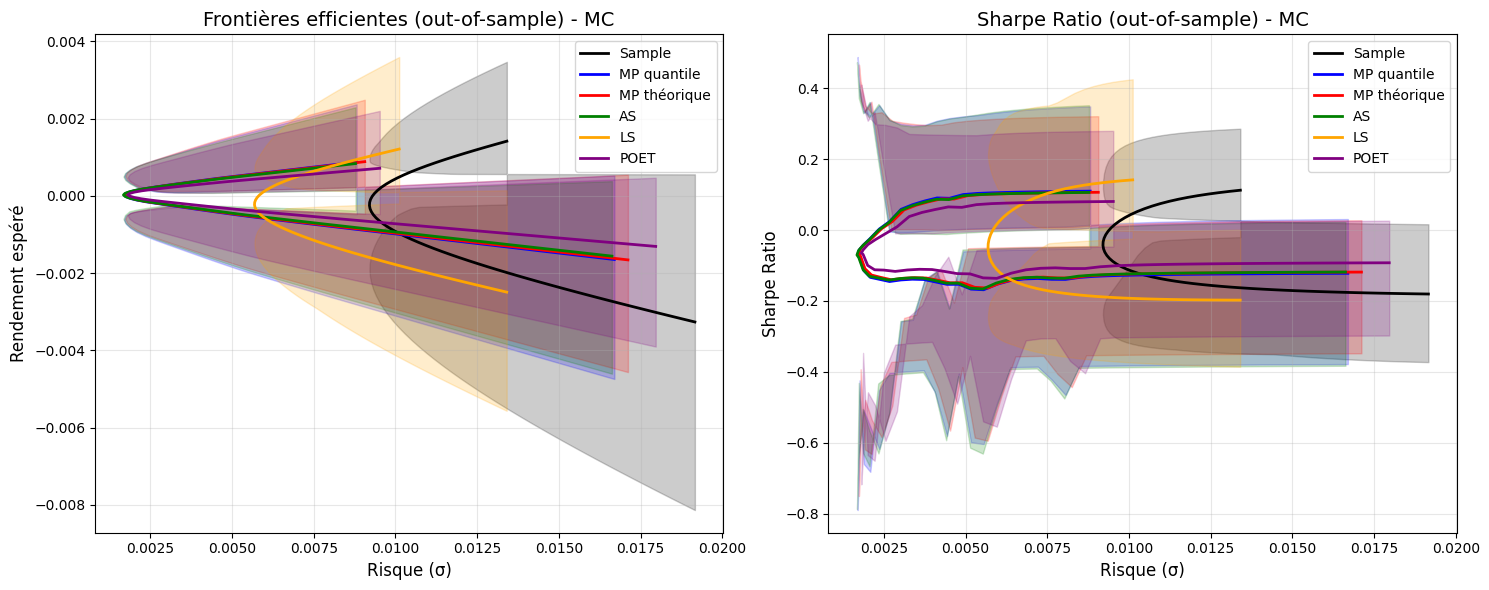

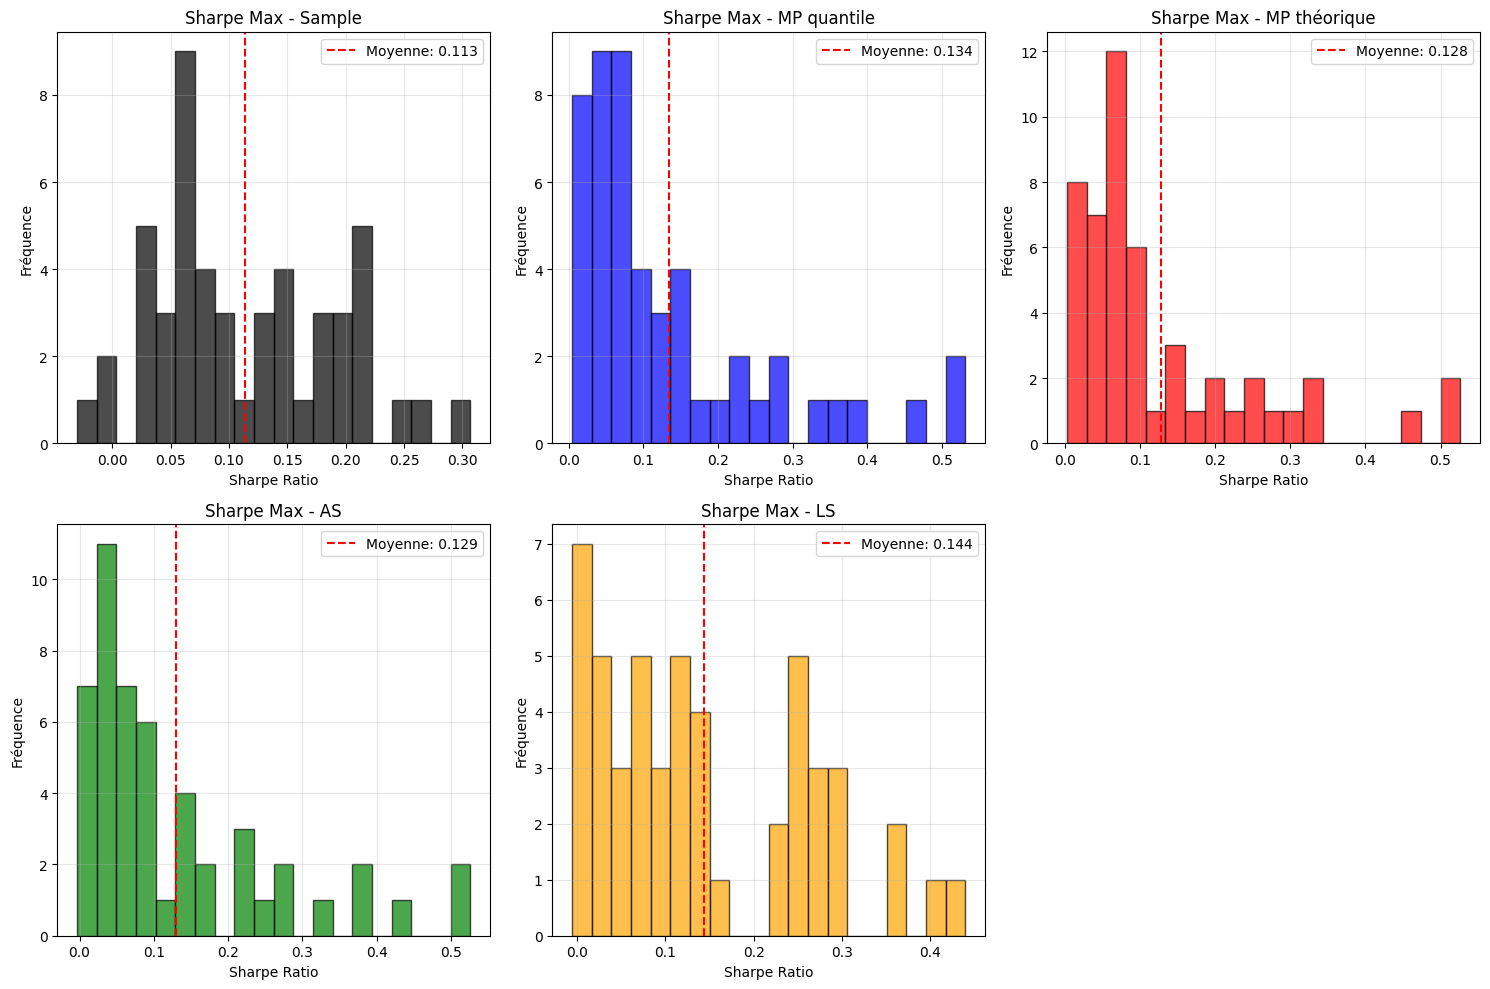


Résumé des résultats du Monte Carlo:


In [10]:
# === VII — Visualisations ===
# Visualisations finales du Monte Carlo (imports centralisés en début)

colors = {
    "Sample": "black",
    "MP quantile": "blue",
    "MP théorique": "red",
    "AS": "green",
    "LS": "orange",
    "POET": "purple"
}

# Plot 1: Frontières efficientes (rendement vs risque)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for name, stats in frontiers_stats.items():
    ax1.plot(stats["risk_mean"], stats["ret_mean"], 
             label=name, color=colors[name], linewidth=2)
    # Error bars basés sur les quantiles 1%/99%
    yerr_lower = np.maximum(stats["ret_mean"] - stats["q1_ret"], 0)
    yerr_upper = np.maximum(stats["q99_ret"] - stats["ret_mean"], 0)
    ax1.fill_between(stats["risk_mean"],
                     stats["ret_mean"] - yerr_lower,
                     stats["ret_mean"] + yerr_upper,
                     color=colors[name], alpha=0.2)

ax1.set_xlabel("Risque (σ)", fontsize=12)
ax1.set_ylabel("Rendement espéré", fontsize=12)
ax1.set_title("Frontières efficientes (out-of-sample) - MC", fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Sharpe Ratio
for name, stats in frontiers_stats.items():
    ax2.plot(stats["risk_mean"], stats["sharpe_mean"], 
             label=name, color=colors[name], linewidth=2)
    # Error bars basés sur les quantiles 1%/99%
    yerr_lower = np.maximum(stats["sharpe_mean"] - stats["q1_sharpe"], 0)
    yerr_upper = np.maximum(stats["q99_sharpe"] - stats["sharpe_mean"], 0)
    ax2.fill_between(stats["risk_mean"],
                     stats["sharpe_mean"] - yerr_lower,
                     stats["sharpe_mean"] + yerr_upper,
                     color=colors[name], alpha=0.2)

ax2.set_xlabel("Risque (σ)", fontsize=12)
ax2.set_ylabel("Sharpe Ratio", fontsize=12)
ax2.set_title("Sharpe Ratio (out-of-sample) - MC", fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 3: Distribution des Sharpe Ratios au maximum
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, stats) in enumerate(frontiers_stats.items()):
    # Trouver l'indice du meilleur Sharpe ratio
    best_idx = np.argmax(stats["sharpe_mean"])
    
    # Collecte tous les Sharpe max des MC
    sharpes_max = []
    for result in results_mc:
        sharpes = result[name][2]
        sharpes_max.append(np.max(sharpes))
    
    axes[idx].hist(sharpes_max, bins=20, alpha=0.7, color=colors[name], edgecolor='black')
    axes[idx].axvline(np.mean(sharpes_max), color='red', linestyle='--', 
                      label=f'Moyenne: {np.mean(sharpes_max):.3f}')
    axes[idx].set_title(f"Sharpe Max - {name}", fontsize=12)
    axes[idx].set_xlabel("Sharpe Ratio")
    axes[idx].set_ylabel("Fréquence")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Supprimer le dernier subplot vide
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

print("\nRésumé des résultats du Monte Carlo:")
print("=" * 60)
for name, stats in frontiers_stats.items():
    best_idx = np.argmax(stats["sharpe_mean"])
    #print(f"  Meilleur Sharpe: {stats['sharpe_mean'][best_idx]:.4f} ± {stats['sharpe_std'][best_idx]:.4f}")
    #print(f"  Risque: {stats['risk_mean'][best_idx]:.4f} ± {stats['risk_std'][best_idx]:.4f}")
    #print(f"  Rendement: {stats['ret_mean'][best_idx]:.4f} ± {stats['ret_std'][best_idx]:.4f}")


In [38]:
import matplotlib.pyplot as plt
n = 252
p = 1974
X_is, X_oos = sample_real_data(R, n, n, p)

mu_is = X_is.mean(axis=0)
sigma = X_is.std(axis=0)
X_is -= mu_is
X_is /= sigma
n,p = np.shape(X_is)
C_is = X_is.T @ X_is / (n-1)
C_is = (C_is + C_is.T)/2

print(np.shape(C_is))
print(n,p)

#C_is = np.corrcoef(X_is, rowvar=False)
eigvals = np.linalg.eigvalsh(C_is)
#eigvals = eigvals[eigvals > 1e-3]

(1974, 1974)
252 1974


min -9.844530215127247e-14
max 473.58442455970965
Lambda plus 10.6936150477244
Lambda moins 1.6131777169777555


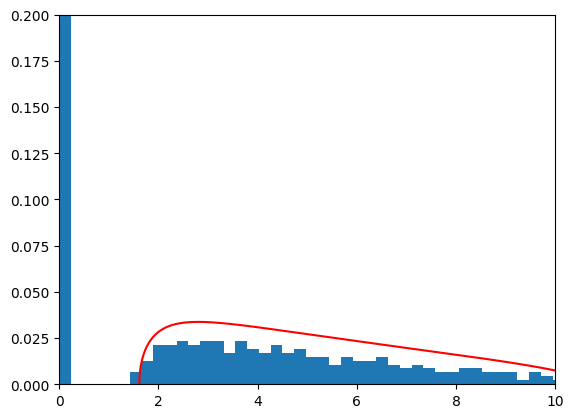

In [39]:
plt.hist(eigvals, bins=2000, density=True)

print('min', np.min(eigvals))
print('max', np.max(eigvals))
lambda_plus_emp = np.percentile(eigvals, 99)
q_eff = 1 / (np.sqrt(lambda_plus_emp) - 1)**2

sigma = 1
g = q_eff
lambda_minus = (1 - np.sqrt(1/g))**2
lambda_plus  = (1 + np.sqrt(1/g))**2

x = np.linspace(lambda_minus, lambda_plus, 1000)
mp = np.sqrt((lambda_plus - x)*(x - lambda_minus)) / (sigma**2 * 2*np.pi*x/g)

plt.plot(x, mp, 'r', label="MP continu")
plt.ylim(0,0.2)
plt.xlim(0,10)

print('Lambda plus', lambda_plus)
print('Lambda moins', lambda_minus)

In [109]:
counts, bin_edges = np.histogram(eigvals, bins=2000, density=False)
mask = (bin_edges[:-1] >= lambda_minus) & (bin_edges[:-1] <= lambda_plus)
print('mass_empirical', np.sum(counts[mask]) / len(eigvals))
print('mass_mp', n / p)

mass_empirical 0.10728744939271255
mass_mp 0.12753036437246965


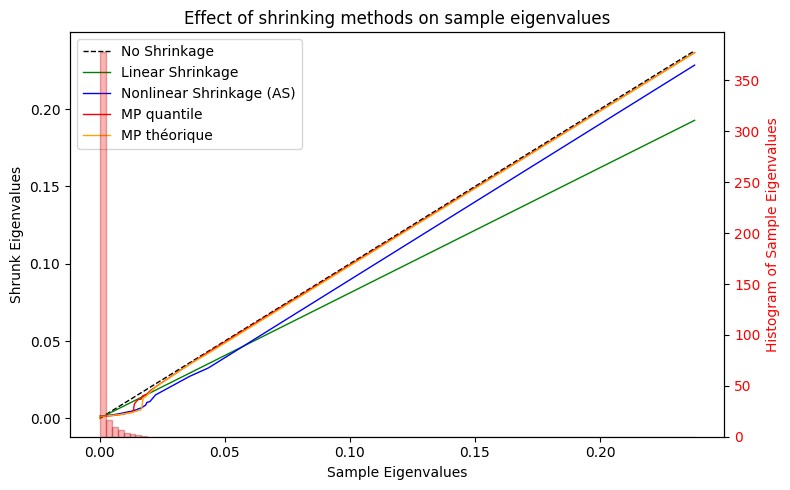

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# === Ton pipeline ===
X_is, X_oos = sample_real_data(R, n_is, n_oos, p)

mu_is = X_is.mean(axis=0)
X_is -= mu_is
X_oos -= mu_is

R_is = X_is.T @ X_is / (n_is-1)

cleaner = cleaning_methods(X_is)

S_mp2 = cleaner.mp2()
S_mp  = cleaner.mp()
S_as  = cleaner.analytical_shrinkage()
S_ls  = cleaner.linear_shrinkage()

# Valeurs propres
eig_is  = np.linalg.eigvalsh(R_is)
eig_mp2 = np.linalg.eigvalsh(S_mp2)
eig_mp  = np.linalg.eigvalsh(S_mp)
eig_ls  = np.linalg.eigvalsh(S_ls)
eig_as  = np.linalg.eigvalsh(S_as)

# Trier par ordre croissant des VP sample
idx = np.argsort(eig_is)
eig_is  = eig_is[idx]
eig_as  = eig_as[idx]
eig_ls  = eig_ls[idx]
eig_mp  = eig_mp[idx]
eig_mp2 = eig_mp2[idx]

# === Plot ===
fig, ax1 = plt.subplots(figsize=(8, 5))

# Courbes shrinkage
ax1.plot(eig_is, eig_is, '--', color='black', linewidth=1, label='No Shrinkage')
ax1.plot(eig_is, eig_ls, color='green', linewidth=1, label='Linear Shrinkage')
ax1.plot(eig_is, eig_as, color='blue', linewidth=1, label='Nonlinear Shrinkage (AS)')
ax1.plot(eig_is, eig_mp, color='red', linewidth=1, label='MP quantile')
ax1.plot(eig_is, eig_mp2, color='orange', linewidth=1, label='MP théorique')

ax1.set_xlabel("Sample Eigenvalues")
ax1.set_ylabel("Shrunk Eigenvalues")
ax1.set_title("Effect of shrinking methods on sample eigenvalues")

# === Histogramme sur axe droit ===
ax2 = ax1.twinx()
ax2.hist(eig_is, bins=100, density=True, alpha=0.3, color='red', edgecolor='darkred')
ax2.set_ylabel("Histogram of Sample Eigenvalues", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Légende
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [70]:
# === MC perte MV (parallélisé, n=252, p=1000..1900 step=100) ===
from joblib import Parallel, delayed
from tqdm import tqdm
n_is = n_oos = 252
p_values = list(range(1000, 1901, 100))
MC = 10
methods = ['Sample', 'MP quantile', 'MP théorique', 'AS', 'LS']
mv_means = {m: [] for m in methods}
mv_stds = {m: [] for m in methods}

def mc_mv_single(p):
    try:
        X_is, X_oos = sample_real_data(R, n_is, n_oos, p)
        mu_is = X_is.mean(axis=0)
        X_is -= mu_is
        X_oos -= mu_is
        R_is = X_is.T @ X_is / (n_is - 1)
        R_os = X_oos.T @ X_oos / (n_oos - 1)
        cleaner = cleaning_methods(X_is)
        S_mp = cleaner.mp()
        S_mp2 = cleaner.mp2()
        S_as = cleaner.analytical_shrinkage()
        S_ls = cleaner.linear_shrinkage()
        S_dict = {'Sample': R_is, 'MP quantile': S_mp, 'MP théorique': S_mp2, 'AS': S_as, 'LS': S_ls}
        out = {}
        for name, S_hat in S_dict.items():
                out[name] = L_mv(S_hat, R_os)
        return out
    except Exception:
        return {m: np.nan for m in methods}

for p in p_values:
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(mc_mv_single)(p) for _ in tqdm(range(MC), desc=f'MC MV p={p}')
    )
    for m in methods:
        arr = np.array([r[m] for r in results], dtype=float)
        mv_means[m].append(np.nanmean(arr))
        mv_stds[m].append(np.nanstd(arr))

print('MC MV (parallélisé) terminé')

MC MV p=1900: 100%|██████████| 10/10 [00:00<?, ?it/s]


MC MV (parallélisé) terminé


In [72]:
# === MC perte Frobenius (parallélisé, n=252, p=1000..1900 step=100) ===
from joblib import Parallel, delayed
from tqdm import tqdm
n_is = n_oos = 252
p_values = list(range(1000, 2001, 150))
MC = 100
methods = ['Sample', 'MP quantile', 'MP théorique', 'AS', 'LS']
frob_means = {m: [] for m in methods}
frob_stds = {m: [] for m in methods}

def mc_frob_single(p):
    try:
        X_is, X_oos = sample_real_data(R, n_is, n_oos, p)
        mu_is = X_is.mean(axis=0)
        X_is -= mu_is
        X_oos -= mu_is
        R_is = X_is.T @ X_is / (n_is - 1)
        R_os = X_oos.T @ X_oos / (n_oos - 1)
        cleaner = cleaning_methods(X_is)
        S_mp = cleaner.mp()
        S_mp2 = cleaner.mp2()
        S_as = cleaner.analytical_shrinkage()
        S_ls = cleaner.linear_shrinkage()
        S_dict = {'Sample': R_is, 'MP quantile': S_mp, 'MP théorique': S_mp2, 'AS': S_as, 'LS': S_ls}
        out = {}
        for name, S_hat in S_dict.items():
            try:
                out[name] = np.linalg.norm(S_hat - R_os, 'fro')**2 / p
            except Exception:
                out[name] = np.nan
        return out
    except Exception:
        return {m: np.nan for m in methods}

for p in p_values:
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(mc_frob_single)(p) for _ in tqdm(range(MC), desc=f'MC Fro p={p}')
    )
    for m in methods:
        arr = np.array([r[m] for r in results], dtype=float)
        frob_means[m].append(np.nanmean(arr))
        frob_stds[m].append(np.nanstd(arr))

print('MC Frobenius (parallélisé) terminé')

MC Fro p=1900: 100%|██████████| 100/100 [09:50<00:00,  5.90s/it]


MC Frobenius (parallélisé) terminé


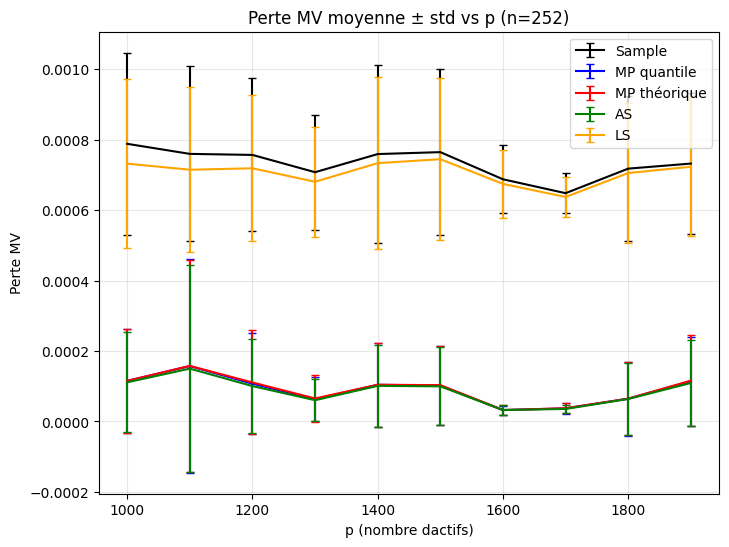

In [76]:
# === Plot pertes MV ===
p_values = list(range(1000, 1901, 100))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
colors = {'Sample': 'black', 'MP quantile': 'blue', 'MP théorique': 'red', 'AS': 'green', 'LS': 'orange'}
for m in methods:
    plt.errorbar(p_values, mv_means[m], yerr=mv_stds[m], label=m, color=colors[m], capsize=3)
plt.xlabel('p (nombre dactifs)')
plt.ylabel('Perte MV')
plt.title('Perte MV moyenne ± std vs p (n=252)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

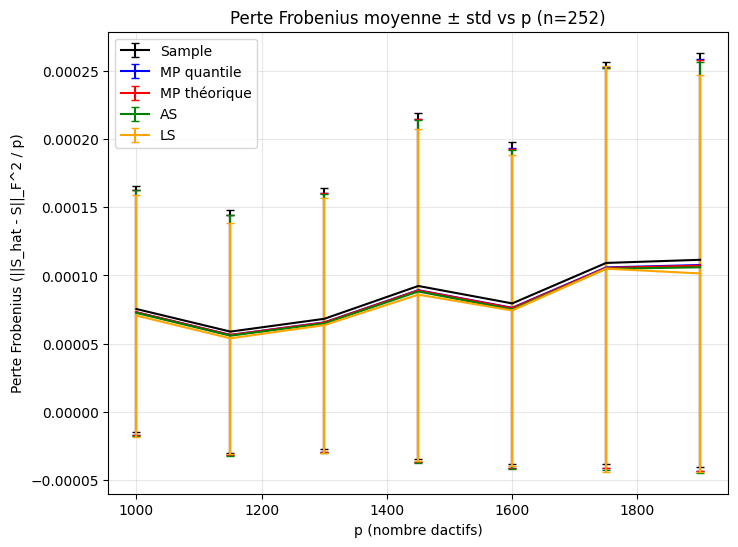

In [81]:
# === Plot pertes Frobenius ===

p_values = list(range(1000, 2001, 150))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for m in methods:
    plt.errorbar(p_values, frob_means[m], yerr=frob_stds[m], label=m, color=colors[m], capsize=3)
plt.xlabel('p (nombre dactifs)')
plt.ylabel('Perte Frobenius (||S_hat - S||_F^2 / p)')
plt.title('Perte Frobenius moyenne ± std vs p (n=252)')
plt.legend()
plt.grid(alpha=0.3)
#plt.ylim(0.00004, 0.00012)
plt.show()